In [1]:
import numpy as np
import re
import h5py as h5
import matplotlib.pyplot as plt
import tables as tb
import pickle
%matplotlib inline
plt.style.use('ggplot')

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

In [7]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
naming = 'Exp6'
side = 'left'
#HDF file generate from Jon's scripts comprising matched candidate labels and filenames.
if naming == 'Exp4':
    #PTID_idx = 0 #Filename has only one PTID
    input_file = baseline_dir + 'HC_preproc/combined.h5'

    # Run this script for each split, side combination:
    split = 'test'

    input_HC = load_data(input_file,'{}_{}_data'.format(side,split))
    #input_classes = input_data['{}_{}_classes'.format(side, split)][:]
    input_files = load_data(input_file,'{}_{}_files'.format(side,split))    
    
if naming == 'Exp6':
    if side == 'left':
        #test from Jon's directory 
        input_file = baseline_dir + 'HC_preproc/tmp/candidate_l_winterburn_factor=0.5_thresh=300_data.h5'
        #input_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_preproc/adni1_and_2/candidate_l_factor=1.0_thresh=300_data.h5'
    else:
        #input_file = '/projects/jp/NI-ML/preprocessing/adni2/04_mask/candidate_right.h5'
        input_file = baseline_dir + 'HC_preproc/tmp/candidate_r_winterburn_factor=0.5_thresh=300_data.h5'
        #input_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_preproc/adni1_and_2/candidate_r_factor=1.0_thresh=300_data.h5'
    
    input_HC = load_data(input_file,'data')
    #input_classes = input_data['{}_{}_classes'.format(side, split)][:]
    input_files = load_data(input_file,'files')    
    
id_participant = re.compile(r"""
 (?<=ADNI_)      # Match the first string after ADNI_
 (.*?)          # Lazy quantifier so it only grabs the first immediate match.
 (?=_MR)        # End at the _MR
""", re.VERBOSE)

In [ ]:
# T100_L = 74865./12756
# T100_R = 71631./13610
# T300_L = 74681./11076
# T300_R = 79392./10161
# T500_L = 62600./9732
# T500_R = 66583./8953
# T750_L = 50276./8713
# T750_R = 55167./8039

# print ' T100_L:{} T100_R:{} \n T300_L:{} T300_R:{} \n T500_L:{} T500_R:{} \n T750_L:{} T750_R:{}'.format(T100_L,T100_R,T300_L,T300_R,T500_L,T500_R,T750_L,T750_R)

In [ ]:
#change HC labels to (-1,1) from (0,1)
#input_HC = 2*input_HC - 1
#cohort_flag = load_data(input_file,'adni1')
tmp_file = '/projects/jp/research/NI-ML/preprocessing/adni1+2_adni-model/hdf/candidate_l.h5'
mask = load_data(tmp_file,'mask')

print np.sum(mask.ravel())
#print len(cohort_flag)
#print '# of adni1_subs: {}'.format(np.sum(cohort_flag))
#print '# of adni2_subs: {}'.format(len(cohort_flag) - np.sum(cohort_flag))
#normed_files = load_data(input_file,'normedfiles')
#print normed_files


In [ ]:
print input_HC.shape
print input_files[:4]
f= input_files[0]
subject_id = re.findall(id_participant, f)
print subject_id
#print input_HC[:3,5000:5100]

In [15]:
# Generate dictionary {subject_id:[candidate_labels]}
import collections
import scipy.stats as stats
subject_idx=[]
unique_subject_idx = []
subject_vol_dict = collections.OrderedDict()
subject_class_dict = collections.OrderedDict()
ADNI1_PTID = 0
ADNI2_PTID = 1
adni1_sub_list = pickle.load( open(baseline_dir + 'CS/adni1_PTIDs.pkl', "rb" ) )
adni2_sub_list = pickle.load( open(baseline_dir + 'CS/adni2_PTIDs.pkl', "rb" ) )
#find volume indices for each unique subject
seen = set([])
ADNI1 = True
ADNI2 = True
candidate_label_list = []
small_HC_list = []
good_HC_list = []
adni1_id_list = []
adni2_id_list = []
missing_id_list = []  

for j, f in enumerate(input_files):
    #subject_id = re.search(id_participant, f).group(0) 
    
    subject_id_list = re.findall(id_participant, f) #ADNI 2 has two sub_id matches - pick the second one [0,1].     
#     if ADNI1 and len(subject_id_list) == 1:
#         subject_id = subject_id_list[ADNI1_PTID] 
#         adni1_id_list.append(subject_id)
#     elif ADNI2 and len(subject_id_list) == 2: 
#         subject_id = subject_id_list[ADNI2_PTID]
#         adni2_id_list.append(subject_id)
#     else:
#         missing_id_list.append(subject_id_list)
#         subject_id = ''
    subject_id = subject_id_list[ADNI2_PTID]
    if ADNI1 and subject_id in adni1_sub_list:
        adni1_id_list.append(subject_id)
    elif ADNI2 and subject_id in adni2_sub_list:
        adni2_id_list.append(subject_id)
    else:
        missing_id_list.append(subject_id_list)
        subject_id = ''
        
    if np.sum(input_HC[j]) ==0:
        small_HC_list.append(input_HC[j])
    else:
        good_HC_list.append(input_HC[j])
        
    if not subject_id == '':
        subject_idx.append(subject_id)
        if (subject_id not in subject_vol_dict) and not (np.sum(input_HC[j]) < 1000):
            subject_vol_dict[subject_id]=[]
            #subject_class_dict[subject_id]=[]

        # check if the candidate label is not empty
        if not np.sum(input_HC[j]) < 1000:        
            subject_vol_dict[subject_id].append(input_HC[j])
            
            #tmp list to find average volumes per side / cohort
            candidate_label_list.append(input_HC[j])
            #subject_class_dict[subject_id].append(input_classes[j])

        if subject_id not in seen:
            unique_subject_idx.append(subject_id)
            seen.add(subject_id)
    
print 'subject_vol_dict length: {}'.format(str(len(subject_vol_dict)))
print 'subject_id_list length: {}'.format(len(subject_idx))    
print 'unique subject_id_list length: {}'.format(len(unique_subject_idx))
print '# of small HCs : {}'.format(len(small_HC_list))
print '# of good HCs : {}'.format(len(good_HC_list))
print '# of adni1 ids: {}'.format(len(adni1_id_list))
print '# of adni2 ids: {}'.format(len(adni2_id_list))
print '# of missing ids: {}'.format(len(missing_id_list))

subject_vol_dict length: 1421
subject_id_list length: 54688
unique subject_id_list length: 1421
# of small HCs : 0
# of good HCs : 56256
# of adni1 ids: 25740
# of adni2 ids: 28948
# of missing ids: 1568


In [ ]:
print len(adni1_sub_list), len(adni2_sub_list), len(list(set(adni1_sub_list)&set(adni2_sub_list)))
#print missing_id_list
#adni1_right_vols = np.array(candidate_label_list)

In [ ]:
#np.array(subject_vol_dict['002_S_4171']).shape
# n_samp = []
# for key in subject_vol_dict.keys():
#     n_samp.append(np.array(subject_vol_dict[key]))
#plt.figure()
#plt.hist(n_samp,bins=100)


print 'hdf5 input shape: {}'.format(input_HC.shape)
print 'adni1_left_vol shape: {}, adni1_right_vol shape: {}'.format(adni1_left_vols.shape, adni1_right_vols.shape)
print 'adni1_left_vol_mean: {}, adni1_right_vol_mean: {}'.format(np.mean(np.sum(adni1_left_vols, axis=1)),np.mean(np.sum(adni1_right_vols, axis=1)))
print 'adni2_left_vol shape: {}, adni2_right_vol shape: {}'.format(adni2_left_vols.shape, adni2_right_vols.shape)
print 'adni2_left_vol_mean: {}, adni2_right_vol_mean: {}'.format(np.mean(np.sum(adni2_left_vols, axis=1)),np.mean(np.sum(adni2_right_vols, axis=1)))


In [11]:
#Save Dictionaries
exp_name = 'Exp6'
cohort = 'ADNI1'

sub_HC_vol_file = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_{}_{}.pkl'.format(cohort,side,exp_name)

import pickle
f = open(sub_HC_vol_file, 'wb')
pickle.dump(subject_vol_dict, f)
f.close()


In [ ]:
factor=0.5_thresh=300
hdf5 input shape: (56256, 16086)
adni1_left_vol shape: (25740, 16086), adni1_right_vol shape: (26350, 16471)
adni1_left_vol_mean: 3891.3535742, adni1_right_vol_mean: 3915.63908918
adni2_left_vol shape: (29041, 16086), adni2_right_vol shape: (28537, 16471)
adni2_left_vol_mean: 3583.71330188, adni2_right_vol_mean: 3615.87945474

factor=0.5_thresh=500       
hdf5 input shape: (44015, 14483)
adni1_left_vol shape: (19220, 14259), adni1_right_vol shape: (20245, 14483)
adni1_left_vol_mean: 3808.33792924, adni1_right_vol_mean: 3831.41007656
adni2_left_vol shape: (22928, 14259), adni2_right_vol shape: (22614, 14483)
adni2_left_vol_mean: 3533.49938939, adni2_right_vol_mean: 3564.90514725



(20, 16086)
left HC shape (20, 16086), np.sum(np.max(X,axis=0)): 7992, diff=8094


/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


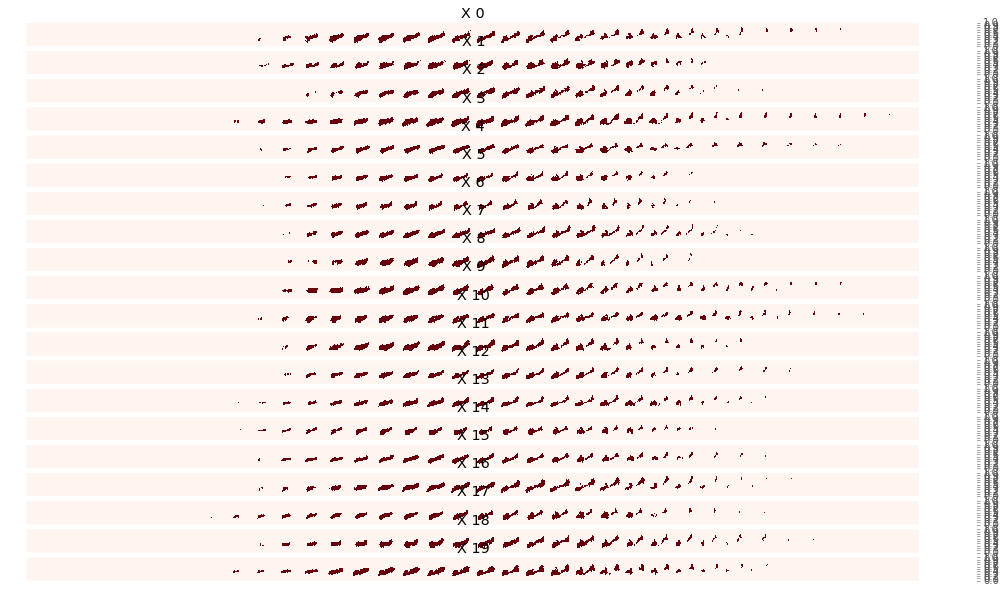

In [14]:
#Visualize HC
import random
plt.rcParams['figure.figsize'] = (20, 10)
input_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_preproc/tmp/candidate_l_winterburn_factor=0.5_thresh=300_data.h5'
datamask =  load_data(input_file.format(side),'datamask')
volmask = load_data(input_file.format(side),'volmask')
baseline_shape = volmask.shape
features = load_data(input_file.format(side),'data')

sampx = 20
X = np.array(random.sample(features,sampx))
print X.shape
max_per_feature = np.max(X,axis=0)
print '{} HC shape {}, np.sum(np.max(X,axis=0)): {}, diff={}'.format(side, X.shape,np.sum(max_per_feature),X.shape[1]-np.sum(max_per_feature))

plot_list = []
for i in np.arange(sampx):    
    plot_list.append((X[i], 'X {}'.format(i)))    
    
plot_slices(plot_list, baseline_shape, datamask)

In [13]:
from scipy.stats.mstats_basic import mquantiles
from sklearn.utils.extmath import randomized_svd

def get3DVol(HC_input, HC_shape, input_mask):
    flatvol = np.zeros(np.prod(HC_shape))
    flatvol[input_mask] = HC_input
    vol = flatvol.reshape(-1, HC_shape[2]).T
    return vol

def plot_slices(slice_list, baseline_shape, baseline_mask, llimit=0.01, ulimit=0.99, xmin=1000, xmax=2400):
    """
    Plot dem slices.
    :param slice_list:
    :param llimit:
    :param ulimit:
    :param num_slices:
    :param xmin:
    :param xmax:
    :return:
    """
    num_slices = len(slice_list)
    plt.style.use('ggplot')
    plt.figure()
    cols = 1
    rows = num_slices / cols
    plt.cla()
    for j, input in enumerate(slice_list):
        quantiles = mquantiles(input[0], [llimit, ulimit])
        wt_vol = get3DVol(input[0], baseline_shape, baseline_mask)
        plt.subplot(rows, cols, j + 1)
        #im = plt.imshow(wt_vol[:, xmin:xmax], cmap=plt.cm.Reds, aspect='auto', interpolation='none', vmin=-.06, vmax=0.06)
        im = plt.imshow(wt_vol, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        plt.grid()
        plt.title(input[1])
        plt.colorbar()
        im.set_clim(quantiles[0], quantiles[1])
        plt.axis('off')

In [ ]:
f = input_files[-4]
subject_id = re.findall(id_participant, f)
print 

In [ ]:
import pickle
sub_DX_data_path = baseline_dir + 'CS/ADNI1_BL_PTID_DX_bl_dict.pkl'
sub_DX_dict = pickle.load( open(sub_DX_data_path, "rb" ) )

X = []
y = []
y_dx = [] #Used for creating balanced k-folds
for key in subject_vol_dict.keys():
    X.append(np.sum(np.squeeze(np.array(stats.mode(subject_vol_dict[key])[0]))))
    y.append(sub_DX_dict[key])
    
X = np.array(X)
y = np.array(y)
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)

In [ ]:
a=0.7
plt.hist(X[y=='AD'],alpha=a,bins=100,label='AD')
plt.hist(X[y=='CN'],alpha=a,bins=100,label='CN')
plt.hist(X[y=='LMCI'],alpha=a,bins=100,label='MCI')
plt.legend()

In [ ]:
plt.subplot(2,1,1)
plt.hist(R_HC_vols)
plt.title('Right HC')
plt.subplot(2,1,2)
plt.hist(L_HC_vols)
plt.title('Left HC')
#R:12386 #L=10262

In [ ]:
print np.array(subject_vol_dict.values()[0]).shape

In [ ]:
import pandas as pd
#Jens atlas stats
voxel_size = 1
fname_L = '/projects/nikhil/current/ADNI/jens/input/atlases/labels/Jens_HC_Left.txt'
fname_R = '/projects/nikhil/current/ADNI/jens/input/atlases/labels/Jens_HC_Right.txt'
vols_L = (voxel_size**3)*np.squeeze(pd.read_csv(fname_L).values)
vols_R = (voxel_size**3)*np.squeeze(pd.read_csv(fname_R).values)

print 'Jens Atlas: '
print 'mean HC vols, L:{}, R:{}'.format(np.mean(vols_L),np.mean(vols_R))
print 'stdev HC vols, L:{}, R:{}'.format(np.std(vols_L),np.std(vols_R))

#Julie atlas stats
voxel_size = 0.3
fname_L = '/projects/nikhil/ADNI_prediction/input_datasets/HC_preproc/Julie_Atlases_tmp/Julie_HC_Left.txt'
fname_R = '/projects/nikhil/ADNI_prediction/input_datasets/HC_preproc/Julie_Atlases_tmp/Julie_HC_Right.txt'
vols_L = (voxel_size**3)*np.squeeze(pd.read_csv(fname_L).values)
vols_R = (voxel_size**3)*np.squeeze(pd.read_csv(fname_R).values)

print 'Julie Atlas:'
print 'mean HC vols, L:{}, R:{}'.format(np.mean(vols_L),np.mean(vols_R))
print 'stdev HC vols, L:{}, R:{}'.format(np.std(vols_L),np.std(vols_R))
